<p align = "center" draggable=”false” ><img src="https://user-images.githubusercontent.com/37101144/161836199-fdb0219d-0361-4988-bf26-48b0fad160a3.png" 
     width="200px"
     height="auto"/>
</p>

# Launch New Products

Today you are a machine learning engineer at the Department of New Products at Target Cosmetics! 

We will start with a small dataset on interactions between users and current products from the past and try to discover substructure, if there's any, by applying some **unsupervised learning** methods. 

Then we will leverage the small amount of labeled data (current products) in combination with a larger amount of unlabeled data (new products to launch) to make estimations as to which products with sell more. 

## Learning Objectives

By the end of this session, you will be able to:

- apply dimensionality reduction techniques to reduce features to a lower dimensional space
- perform customer segmentation, determine optional number of clusters, and understand assumptions for used algorithm
- understand what semi-supervised learning is and leverage it to improve performance of supervised learning

## Task 1. Dimensionality Reduction

1. Load in the data. 
    
    Import `pandas` as `pd` and use `pd.read_csv()` to read in `past.csv.gz` in the `dat` folder, saving it as `past`. 
    
    Data in `past.csv.gz` was propcessed; e.g., features indicating time of day, day of week, month, and year of the purchase have been converted to one-hot representations of these categories. 

In [267]:
import pandas as pd

In [268]:
past = pd.read_csv('/Users/matthewcastelli/Desktop/FourthBrain/FourthBrainMC/assignments/week-7-unsuper-lrn/dat/past.csv.gz')

In [269]:
past.columns

Index(['product_id', 'user_id', 'NumOfEventsInJourney', 'NumSessions',
       'interactionTime', 'maxPrice', 'minPrice', 'NumCart', 'NumView',
       'NumRemove', 'InsessionCart', 'InsessionView', 'InsessionRemove',
       'Weekend', 'Fr', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed', '2019',
       '2020', 'Jan', 'Feb', 'Oct', 'Nov', 'Dec', 'Afternoon', 'Dawn',
       'EarlyMorning', 'Evening', 'Morning', 'Night', 'Purchased?', 'Noon',
       'Category'],
      dtype='object')

<details>
<summary> Expected output </summary>

```
Index(['product_id', 'user_id', 'NumOfEventsInJourney', 'NumSessions',
       'interactionTime', 'maxPrice', 'minPrice', 'NumCart', 'NumView',
       'NumRemove', 'InsessionCart', 'InsessionView', 'InsessionRemove',
       'Weekend', 'Fr', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed', '2019',
       '2020', 'Jan', 'Feb', 'Oct', 'Nov', 'Dec', 'Afternoon', 'Dawn',
       'EarlyMorning', 'Evening', 'Morning', 'Night', 'Purchased?', 'Noon',
       'Category'],
      dtype='object')
```
</details>

2. What percentage of the interactions (rows) resulted in a purchase?

    Do people mostly buy what they look at or do they do a lot of "window shopping" (shopping around without buying)?
    
    From the classification perspective, is the data balanced?

In [270]:
print(past['Purchased?'].mean()) # .3448

0.3438


3. Drop `product_id` and `user_id` and save the rest columns to a new `pd.DataFrame`:`X`; then pop the column `'Purchased?'` and save it to `y`.

In [271]:
X = past.drop(['product_id', 'user_id', 'Purchased?'], axis=1)
y = past['Purchased?']

In [272]:
assert X.shape == (5000, 34)
assert y.shape == (5000,)

4. Apply [PCA (check documentation if unfamiliar)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to reduce the number of features down to **5**, save it to an numpy array named `X_reduced`. 

    Do you need to preprocess the data before performing PCA? Quick review [here: Importance of feature scaling](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html).
    
    If time permits, read [Does mean centering or feature scaling affect a Principal Component Analysis?](https://sebastianraschka.com/faq/docs/pca-scaling.html) or [discussion 1](https://stats.stackexchange.com/questions/53/pca-on-correlation-or-covariance).

In [273]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=5, whiten=True)
X_norm = StandardScaler().fit_transform(X)
X_reduced = pca.fit_transform(X_norm)


In [274]:
assert X_reduced.shape == (5000, 5)

5. Print out the percentage of variance explained by each of the selected components.

In [275]:
print(pca.explained_variance_ratio_)

[0.10282101 0.09445884 0.06511866 0.05131168 0.0420416 ]


6. Review code in functions `visualize_2pcs` and `visualize_3pcs` below and visualize first few principal components in 2D and 3D plots, respectively:

In [276]:
import matplotlib.pyplot as plt

def visualize_2pcs(pcs, y):
    fig, ax = plt.subplots()
    plot = plt.scatter(pcs[:,0], pcs[:,1], c=y) 
    ax.legend(
        handles=plot.legend_elements()[0], 
        labels=['No', 'Yes'])

In [277]:
def visualize_3pcs(pcs, y):
    fig, ax = plt.subplots()
    ax = fig.add_subplot(projection='3d')
    plot = ax.scatter(pcs[:,0], pcs[:,1], pcs[:,2], c=y)
    ax.legend(
        handles=plot.legend_elements()[0], 
        labels=['No', 'Yes'])

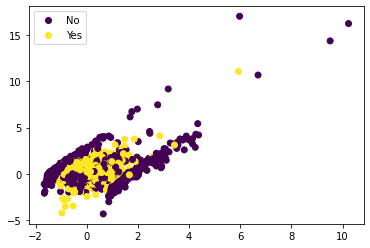

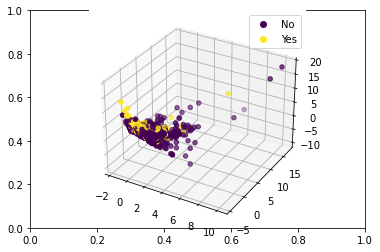

In [278]:
visualize_2pcs(X_reduced, y)
visualize_3pcs(X_reduced, y)

7. One way to assess the quality of the dimensionality reduction, when the groundtruth is available of course, is comparing the prediction performance using given features vs reduced (engineered) features.

    Complete the wrapper function below that 

    - takes features, target, and a boolean parameter indicating whether to include standardization in the pipeline or not
    - split the data into train (80%) and test (20%) datasets, set the random state for spliting at 0
    - build a pipeline that 

        1) preprocessing data using standardization if the `standardize` is `True`; otherwise skip this step  

        2) apply logistic regression ( do you consider data is balanced? )
        
    - fit the pipeline using training data
    - print the classification report (use `sklearn.metrics.classification_report`) on test data

In [279]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

def train(X, y, standardize = True) -> None:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

    if standardize == True:
        pipeline = Pipeline(
            steps = [
                ('scaler', StandardScaler()),
                ('lRegression', LogisticRegression(class_weight='balanced'))
            ]
        )
    else:
        pipeline = Pipeline(
            steps = [
                ('lRegression', LogisticRegression(class_weight='balanced'))
            ]
        )

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    print(classification_report(y_test, y_pred))
    

Now apply the pipeline on the all the features `X` and review the performance

In [280]:
train(X, y, True)

              precision    recall  f1-score   support

           0       0.75      0.77      0.76       649
           1       0.55      0.52      0.54       351

    accuracy                           0.68      1000
   macro avg       0.65      0.65      0.65      1000
weighted avg       0.68      0.68      0.68      1000



Similarly, apply the pipeline on the reduced / engineered features `X_reduced`. Should you include standardization in the pipeline?

In [281]:
train(X_reduced, y, False)

              precision    recall  f1-score   support

           0       0.74      0.72      0.73       649
           1       0.51      0.53      0.52       351

    accuracy                           0.66      1000
   macro avg       0.62      0.63      0.62      1000
weighted avg       0.66      0.66      0.66      1000



8. Are the results as expected? Discuss the pros and cons using reduced set of features in this application with your teammate. 
    *YOUR ANSWER HERE*

## Task 2. Customer Segmentation

In this task, we apply k-means clustering on the reduced data, experimenting different vaules of `n_cluster`, summarize all this information in a single plot, the *Elbow* plot. In addition, leverage silhouette visualization to help decide the "optimal" number of clusters in our data and answer: 

1. Are there any patterns among customer purchasing behaviors?
2. If so, what categories do they belong to? How do you characterize the clusters?
3. If not, what followup steps and / or recommendations will you make as an MLE?

1. Look up the [documentation](https://scikit-learn.org/stable/modules/clustering.html) and import the model class for k-means from `sklearn.cluster`

In [282]:
from sklearn.cluster import KMeans

2. Complete `visualize_elbow`; inspect the code and complete

    - fit k-means on the given data `X` and `k`, setting `random_state` to be 10 for reproducibility
    - append the sum of squared distances of samples to their closest cluster center for each $k$ to list `inertias`

In [283]:
def visualize_elbow(X, ks):
    fig, ax = plt.subplots()
    inertias = []
    for k in ks:
        kmeans = KMeans(n_clusters=k, random_state=10)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
    plt.plot(ks, inertias)
    plt.xticks(ks)
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow plot')

3. Visualize the elbow plot for the number of clusters ranging between 2 and 9. Discuss with your teammate, what is the 'optimal' number of clusters?

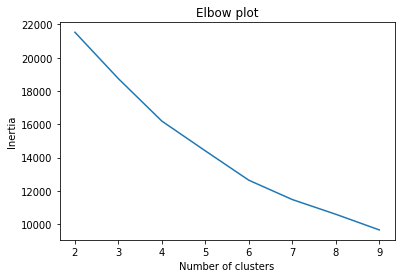

In [284]:
visualize_elbow(X_reduced, range(2,10))

4. What are the disadvantage to use the Elbow method? 

Sometimes it is not clear what clusters are optimal for the model, such as the elbow plot that is created in this situation. There is no definite outcome.

5. Let's try a different approach: [silhouette score](https://towardsdatascience.com/clustering-metrics-better-than-the-elbow-method-6926e1f723a6).

    A helper function `visualize_silhouette` is provided for you (inspect the code in `utils.py`) and figure out how to use it to visualize k-means for k ranges from 2 to 8 on the reduced data. 

In [285]:
from utils import visualize_silhouette

For n_clusters = 2 The average silhouette_score is : 0.200028910249771
For n_clusters = 3 The average silhouette_score is : 0.21108331909111402
For n_clusters = 4 The average silhouette_score is : 0.2196065105578075
For n_clusters = 5 The average silhouette_score is : 0.2259167543685104
For n_clusters = 6 The average silhouette_score is : 0.20492138977075525
For n_clusters = 7 The average silhouette_score is : 0.2070384451338523
For n_clusters = 8 The average silhouette_score is : 0.21989787613191547


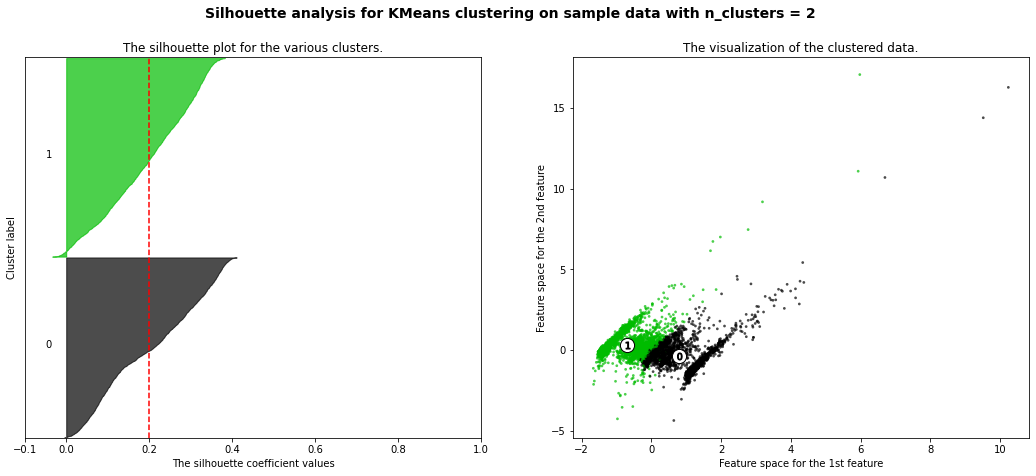

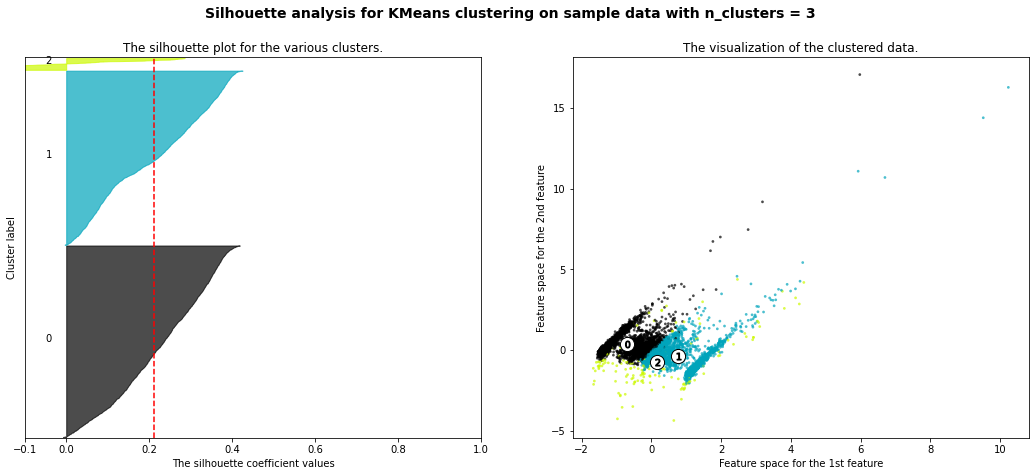

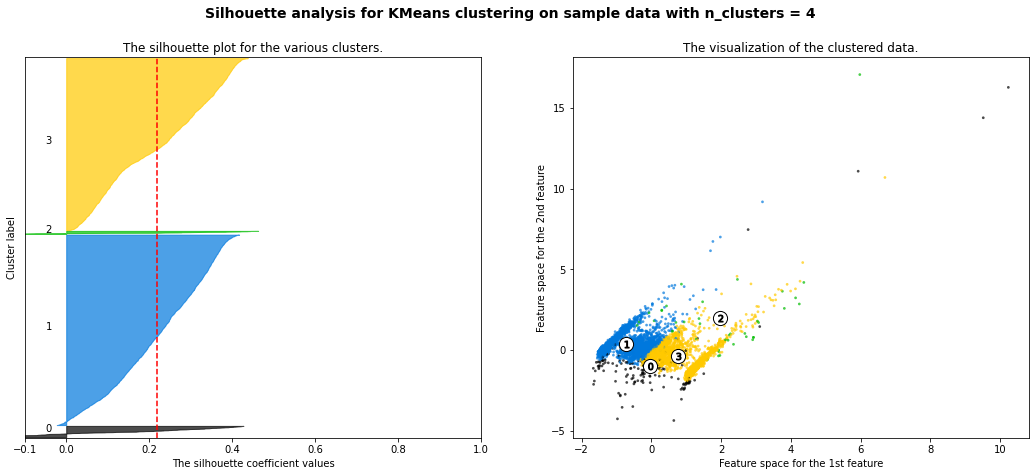

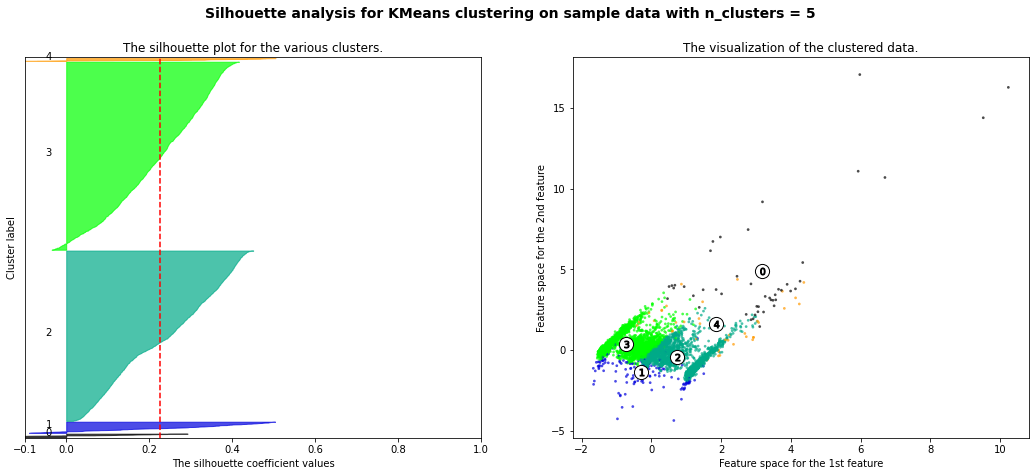

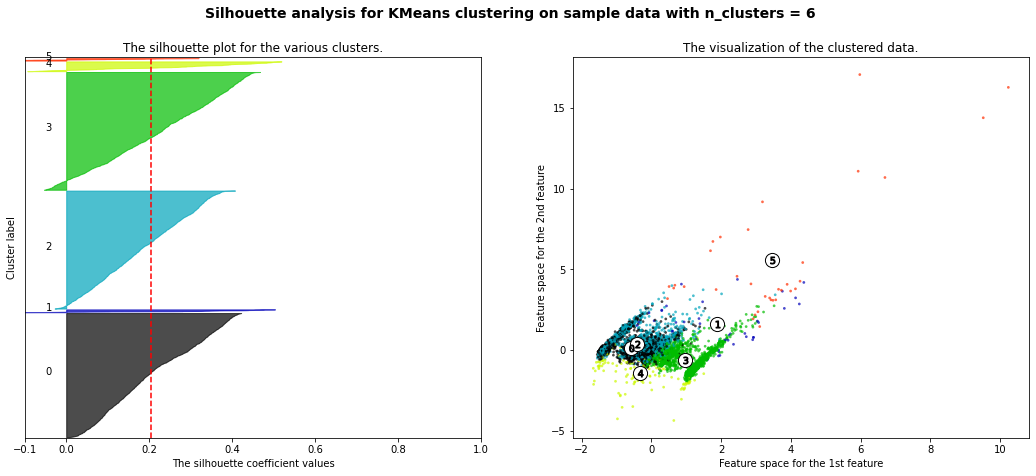

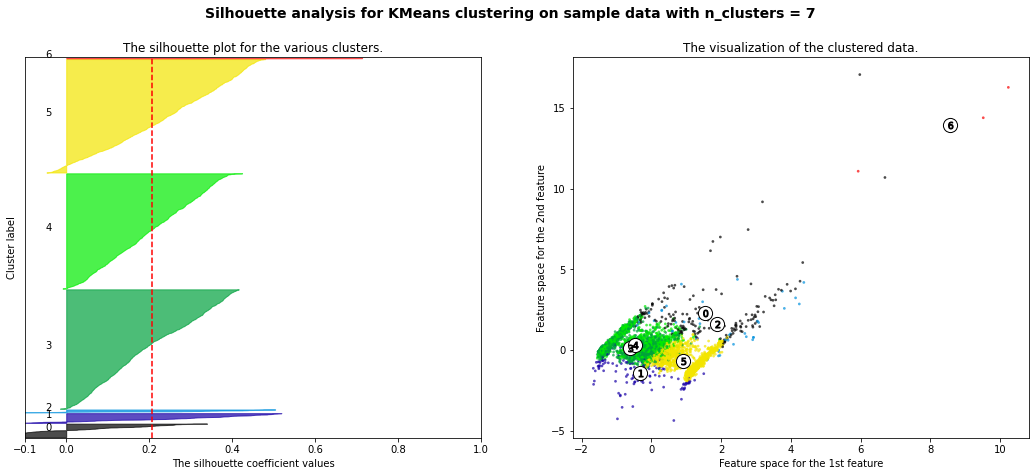

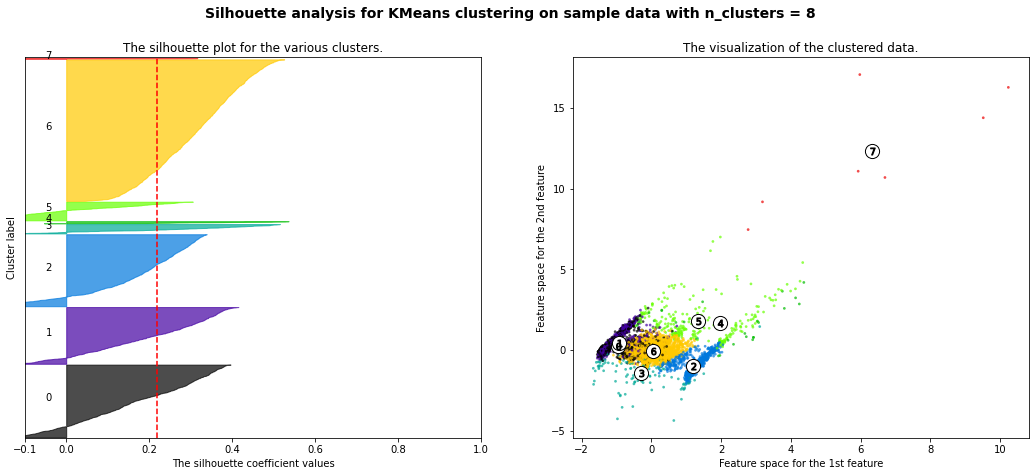

In [286]:
visualize_silhouette(max_clusters=8, X=X_reduced)

6. Instantiate a k-mean model using the number of cluster that you deem optimal, assign it to `km`, and fit on the reduced data. 

In [287]:
%%time
km = KMeans(n_clusters=4, random_state=10).fit(X_reduced)

CPU times: user 751 ms, sys: 2.37 s, total: 3.12 s
Wall time: 337 ms


7. What is the size of each cluster? 

In [288]:
for i in range(len(km.cluster_centers_)):
  print("Cluster", i)
  print("Center:", km.cluster_centers_[i])
  print("Size:", sum(km.labels_ == i))

Cluster 0
Center: [-0.04133521 -0.9669614   3.55316848  2.13753403 -0.08598003]
Size: 149
Cluster 1
Center: [-0.71373768  0.36757994 -0.05005243 -0.04236845 -0.02714648]
Size: 2528
Cluster 2
Center: [ 1.9768152   1.99761563 -3.29574522  6.67319372 -1.85330886]
Size: 40
Cluster 3
Center: [ 0.75968552 -0.37957239 -0.11878985 -0.20965723  0.06822621]
Size: 2283


8. Create a new column called `cluster_pca` in `past`, with values as predicted cluster index predicted by `km`. 

In [289]:
from IPython.display import display
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [290]:
past['cluster_pca'] = km.labels_


In [291]:
cluster0 = past[past.cluster_pca == 0]
cluster1 = past[past.cluster_pca == 1]
cluster2 = past[past.cluster_pca == 2]
cluster3 = past[past.cluster_pca == 3]

In [292]:
display(cluster0.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
product_id,149.00,5487354.55,1392021.15,5379.00,5784127.00,5862003.00,5892732.00,5931773.00
user_id,149.00,534472942.49,53982047.32,143995345.00,517476048.60,545377195.67,564790021.33,615128468.00
NumOfEventsInJourney,149.00,2.03,3.36,1.00,1.00,1.33,1.80,28.00
NumSessions,149.00,1.66,3.05,1.00,1.00,1.12,1.32,28.00
interactionTime,149.00,265346.99,925918.08,0.00,0.00,2593.33,185220.00,7331787.00
maxPrice,149.00,57.97,33.95,1.59,38.73,46.06,63.33,236.51
minPrice,149.00,57.92,33.95,1.35,38.73,46.06,63.26,236.51
NumCart,149.00,0.15,0.34,0.00,0.00,0.00,0.20,3.00
NumView,149.00,1.73,3.16,0.00,1.00,1.17,1.45,28.00
NumRemove,149.00,0.10,0.29,0.00,0.00,0.00,0.07,2.00


In [293]:
display(cluster1.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
product_id,2528.00,5545683.00,1202185.83,4104.00,5750353.00,5823461.00,5862972.50,5916644.00
user_id,2528.00,515004031.13,59054426.77,65241811.00,493918157.85,528152484.57,555974175.87,597114550.50
NumOfEventsInJourney,2528.00,1.94,1.06,1.00,1.00,1.80,2.33,16.00
NumSessions,2528.00,1.31,0.49,1.00,1.00,1.17,1.50,9.00
interactionTime,2528.00,195670.90,443348.40,0.00,0.00,3932.13,190997.85,5372841.00
maxPrice,2528.00,5.67,5.19,0.00,2.38,4.14,6.83,32.97
minPrice,2528.00,5.64,5.18,0.00,2.38,4.13,6.79,32.97
NumCart,2528.00,0.55,0.57,0.00,0.00,0.50,0.86,7.00
NumView,2528.00,0.87,0.64,0.00,0.50,1.00,1.00,10.20
NumRemove,2528.00,0.41,0.56,0.00,0.00,0.25,0.67,7.00


In [294]:
display(cluster2.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
product_id,40.00,5856184.40,66894.83,5711723.00,5824379.00,5884413.50,5905259.00,5931329.00
user_id,40.00,496465540.35,89829462.89,131994138.00,454020883.12,497593427.00,568233448.00,610706326.00
NumOfEventsInJourney,40.00,3.54,6.12,1.00,1.62,2.00,4.00,40.00
NumSessions,40.00,1.43,0.51,1.00,1.00,1.33,2.00,3.00
interactionTime,40.00,872949.58,1496479.67,0.00,0.00,3427.00,1385004.38,5230720.00
maxPrice,40.00,4.47,3.89,0.00,1.49,3.99,6.12,17.46
minPrice,40.00,4.08,4.07,0.00,0.93,3.09,6.12,17.46
NumCart,40.00,1.15,0.86,0.00,0.73,1.00,1.00,4.00
NumView,40.00,0.35,0.71,0.00,0.00,0.00,0.50,4.00
NumRemove,40.00,2.03,5.95,0.00,0.25,1.00,1.75,38.00


In [295]:
display(cluster3.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
product_id,2283.00,5605469.20,1107758.75,4185.00,5771450.00,5839093.00,5884259.50,5932538.00
user_id,2283.00,532727966.56,59230573.95,121915612.00,507370704.15,540309656.00,571750604.50,622026195.00
NumOfEventsInJourney,2283.00,1.93,1.09,1.00,1.00,1.75,2.31,20.00
NumSessions,2283.00,1.32,0.50,1.00,1.00,1.18,1.50,6.00
interactionTime,2283.00,296104.37,851691.49,0.00,0.00,3578.90,226436.50,10875369.00
maxPrice,2283.00,6.20,5.71,0.00,2.54,4.55,7.46,35.56
minPrice,2283.00,6.16,5.69,0.00,2.52,4.49,7.45,35.56
NumCart,2283.00,0.55,0.55,0.00,0.00,0.50,0.90,12.00
NumView,2283.00,0.88,0.63,0.00,0.50,1.00,1.00,8.00
NumRemove,2283.00,0.40,0.54,0.00,0.00,0.22,0.60,4.00


9. Open ended: manipulate `past` and see if you can characterize each cluster (e.g., calculate statistics of / visualize features for each cluster), how will you intepret the results? 

    **Note**. This is probably the most important part as far as the business stakeholders are concerned: "*What can I do with your results?*" The math, modeling part is relatively easy, compared to actionable recommendations you make for business. Thus, before jumping on a different algorithm for the given task, do you best to 1) understand the data in depth 2) keep buisiness use cases in mind throughout all steps. 

- Cluster 0: The average customer where most transactions are within 2020 (aka new customer cluster)
- Cluster 1: The average customer but mostly within 2019 (most likely a cluster of a lot of churned customers)
- Cluster 2: Thoughtful customers that consider a lot of products and spend a long time interacting
- Cluster 3: High Price, Low Quantity

10. What are the assumptions for k-means? Judging by the cluster sizes, is k-means a good approach? 

    Scanning the list of [clustering algorithms](https://scikit-learn.org/stable/modules/clustering.html) implemented in scikit-learn, try at least one other algorithm, examine its assumptions, and intepret results.

- Clustering Algorithm: K-Means
    - Assumptions:
        - Assumes the variance of each cluster is spherical
        - all variables have the same variance
        - takes a naive approach for each cluster
    - Is this a good approach?
        - Since the dataset does not include a lot of data, KMeans is not a bad choice but if the dataset grow, scalability would be an issue

- Clustering Algorithm: Mean-Shift
    - Assumptions:
        - Better in lower dimensions where time complexity averages O(T*n*log(n)), rather than O(T*n^2) with high dimensionality
    - Is this a good approach?
        - In terms of dimensionality, this clustering algorithm would serve well, however, the way that the clusters are formed are not beneficial for this dataset since almost all the data is concentrated in one location in the bottom left corner of our graph

In [296]:
from sklearn.cluster import MeanShift

ms = MeanShift().fit(X_reduced)

In [297]:
for i in range(len(ms.cluster_centers_)):
  print("Cluster", i)
  print("Center:", ms.cluster_centers_[i])
  print("Size:", sum(ms.labels_ == i))

Cluster 0
Center: [-0.26491986  0.06686627 -0.12029222 -0.14728831  0.0017591 ]
Size: 4726
Cluster 1
Center: [ 3.28170698  2.96419806  1.75589541 -0.67799232  0.44217681]
Size: 45
Cluster 2
Center: [ 0.60791433  1.60925541 -2.61203722  4.87335237 -1.70580274]
Size: 19
Cluster 3
Center: [ 3.53912568  3.14656358  2.83490341 -1.49221087 -0.93589551]
Size: 10
Cluster 4
Center: [ 1.82456017 -0.00788788 -2.700334    4.34977446 -1.08670284]
Size: 17
Cluster 5
Center: [-0.8940231  -2.52601335  7.55598513  6.0961811  -0.0371044 ]
Size: 8
Cluster 6
Center: [ 1.66266733  3.52423569  3.4855081  -1.76626754 -1.631375  ]
Size: 4
Cluster 7
Center: [ 2.91934441  0.73969736 -5.63228199 12.25805565 -2.91071979]
Size: 3
Cluster 8
Center: [ 2.33337386  0.35395435 -3.20060185  6.86370868 -0.77302576]
Size: 3
Cluster 9
Center: [ 0.29791726  2.46168561 -3.93225033  8.64721899 -5.18899814]
Size: 2
Cluster 10
Center: [-0.25528061  0.48017631 -2.08662873  1.8606586  -5.19375231]
Size: 7
Cluster 11
Center: [-0.6

11. Jot down recommendations or followup steps, detailing the reasons.

- Find ways to retain customers that are churning (cluster 1) and new customers (cluster0)
- Understand cluster2 customer intentions as they spend the most time on the platform
- Offer bundles or deals that could potentially attract more purchased from cluster3 since they are more likely to be less frequent but buy more expensive products

## Task 3. To launch or not to launch?

In this task, we will work on a hypothetical application: cosmetics purchase prediction for new products with limited features. The intention here is to maximize **recall** so that no popular cosmetic is understocked. Overstocking is less of a concern since it will not cause disengagement in customers.

The purchase status for each "new" product is known, but we only use the labels for benchmarking purpose. Instead, we use label spreading method to leverage a small amount of labeled data in combination with a larger amount of unlabeled data. 

1. Read in the data in `new.csv.gz` and save it as a `pd.DataFrame` named `new`. This is the test dataset.

    Look at the shape of `new` and inspect the frist few rows.

In [298]:
new = pd.read_csv('/Users/matthewcastelli/Desktop/FourthBrain/FourthBrainMC/assignments/week-7-unsuper-lrn/dat/new.csv.gz')

In [299]:
assert new.shape == (30091, 5)

In [300]:
new.head()

,product_id,maxPrice,minPrice,Purchased?,Category
0,5866502,7.62,7.62,0,1.00
1,5870408,6.27,6.27,0,3.00
2,5900580,10.01,10.01,0,1.00
3,5918778,5.98,5.98,0,2.50
4,5848772,26.83,26.83,0,1.00


2. How does the number of data points in the training set (`past`) compare to the number of datapoints in the test set (`new`)? 

    And how does the feature set in the training set compare to the feature set in the test set?

There are less samples and less features in the new dataset compared to the past dataset

    *The number of datapoints in the training set is relatively small while the test set is quite large. The training set has more features than in the test set.*

3. Are there any product ids in both the training and test datasets? Hint: use `np.intersect1d` or set operations.

In [301]:
new_products = set(new.product_id)
past_products = set(past.product_id)

intersect = new_products.intersection(past_products)
print(len(intersect))

0


4. What percentage of data points resulted in a purchase in the test set?

    In reality, we won't be able to calculate information that is not available to you. Here, we simply demonstrated that the distributions in target between `past` and `new` are similar. 

In [302]:
new['Purchased?'].mean() # ~.344

0.3442557575354757

5. Create `ndarray`s: `X_train`, `y_train`, `X_test`, and `y_test` according to the following guidelines.

    - The `Purchased?` column is the target.
    - `X_train` and `X_test` should contain the same features
    - `product_id` should not be a feature.

    Double check that the shapes of the four arrays are what you expect.

In [354]:
import numpy as np
train_df = new
test_df = past.sample(n=5000)

X_train = np.array(train_df.drop(['product_id', 'Purchased?'], axis=1))
y_train = np.array(train_df.pop('Purchased?'))

X_test = np.array(test_df[['maxPrice', 'minPrice', 'Category']])
y_test = np.array(test_df.pop('Purchased?'))

In [355]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(30091, 3)
(30091,)
(5000, 3)
(5000,)


In [356]:
assert X_train.shape[0] == y_train.shape[0] # 5000
assert X_train.shape[1] == X_test.shape[1]  # 3

assert type(X_train) == np.ndarray # make sure you import numpy as np at this point
assert type(X_train).__module__ == type(y_train).__module__ == np.__name__  # alternative way

6. Let's fit a simple logistic regression on the training set (`X_train`, `y_train`) and report performance on the test set (`X_test`, `y_test`).

In [357]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

lr = LogisticRegression(class_weight='balanced').fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.93      0.86      3281
           1       0.81      0.53      0.64      1719

    accuracy                           0.79      5000
   macro avg       0.80      0.73      0.75      5000
weighted avg       0.80      0.79      0.78      5000



7. Re-assemble data for semi-supervised learning. 
    - Use the features from the test set along with the features from the training set. 
    - Only use the labels from the training set but none from the test set.  
    
    Since we're using a large number of sampled features, but only a small number of these samples have labels, this is **semi-supervised learning**.

Create a matrix `X` that has the rows from `X_train` concatenated with the rows from `X_test`. Check the shape of the matrix.

In [358]:
X = np.vstack((X_train, X_test))

In [359]:
assert X.shape == (35091, 3)

Create the target array `y` by concatenating `y_train` with a vector of -1's, effectively creating a dummy label for the `X_test` rows in `X`. Check the shape of the array. It should have as many values as `X` has rows.

In [377]:
X_dummy = np.ones((5000, 1)) * -1

y = np.vstack((y_train.reshape(-1,1), X_dummy))

In [378]:
assert X.shape[0] == y.shape[0]

8. Semi-supervised learning. 

    Scikit-learn provides two label propagation models: [`LabelPropagation`](https://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelPropagation.html) and [`LabelSpreading`](https://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelSpreading.html). Both work by constructing a similarity graph over all items in the input dataset. `LabelSpreading` is similar to the basic Label Propagation algorithm, but it uses an affinity matrix based on the normalized graph Laplacian and soft clamping across the labels; thus more robust to noise. We will be using scikit-learn's `LabelSpreading` model with `kNN`.
    
    Train a `LabelSpreading` model. Set `kernel` to `knn` and `alpha` to 0.01.

In [384]:
from sklearn.semi_supervised import LabelSpreading

ls = LabelSpreading(kernel="knn", alpha=.01).fit(X,y)

/opt/homebrew/Caskroom/miniforge/base/envs/FB/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


9. Extract the predictions for the test data. 

    You can get the predictions from the `transduction_` attribute. Note that there is a value for every row in `X`, so select just the values that correspond to `X_test`.

In [407]:
semi_sup_preds = ls.transduction_[-5000:]

In [410]:
assert semi_sup_preds.shape[0] == X_test.shape[0]

10. Print the classification report

In [411]:
print(classification_report(y_test, semi_sup_preds)) # make sure you properly import classification_report

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      3281
           1       0.85      0.73      0.79      1719

    accuracy                           0.86      5000
   macro avg       0.86      0.83      0.84      5000
weighted avg       0.86      0.86      0.86      5000



Let's bring the performance from the supervised learning model down to see the comparison; discuss the areas of improvement and reasons for improvement.

In [412]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.93      0.86      3281
           1       0.81      0.53      0.64      1719

    accuracy                           0.79      5000
   macro avg       0.80      0.73      0.75      5000
weighted avg       0.80      0.79      0.78      5000



Precision, recall, and F1 score all increased. This is most likely the case due to the way semi-supervised training is conducted compared to normal supervised learning. For semi-supervised learning the training will consist of all rows whether there are labels or not and will try to infer the labels based on the labeled data and train with predictions leading to more volume training data. Semi-supervised learning takes advantage of all the data whether it is labeled or not.

11. Read [Small Data Can Play a Big Role in AI](https://hbr.org/2020/02/small-data-can-play-a-big-role-in-ai) and discuss with your teammate about AI tools for training AI with small data and their use cases. 

## Acknowledgement & References

- data was adapted from Kaggle: [eCommerce Events History in Cosmetics Shop](https://www.kaggle.com/mkechinov/ecommerce-events-history-in-cosmetics-shop)
- function `visualize_silhouette` was adapted from [plot_kmeans_silhouette_analysis by scikit-learn](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
- [Categorizing Online Shopping Behavior from Cosmetics to Electronics: An Analytical Framework](https://arxiv.org/pdf/2010.02503.pdf)
- [OPAM: Online Purchasing-behavior Analysis using Machine learning](https://arxiv.org/pdf/2102.01625.pdf)